In [ ]:
from google.colab import files

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import pylab as pl
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
file = files.upload()

Saving test_sessions.csv to test_sessions.csv
Saving train_sessions.csv to train_sessions.csv


In [ ]:
train_df = pd.read_csv('train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('test_sessions.csv', index_col='session_id')
train_df.head(10)

site1                time1  ...               time10 target
session_id                              ...                            
1             718  2014-02-20 10:02:45  ...                  NaN      0
2             890  2014-02-22 11:19:50  ...  2014-02-22 11:20:16      0
3           14769  2013-12-16 16:40:17  ...  2013-12-16 16:40:24      0
4             782  2014-03-28 10:52:12  ...  2014-03-28 10:56:42      0
5              22  2014-02-28 10:53:05  ...  2014-02-28 10:57:11      0
6             570  2014-03-18 15:18:31  ...                  NaN      0
7             803  2014-02-13 16:45:35  ...  2014-02-13 16:47:17      0
8              22  2013-04-12 10:27:26  ...  2013-04-12 10:27:32      0
9             668  2014-03-17 16:23:08  ...  2014-03-17 16:23:53      0
10           3700  2014-02-20 16:09:13  ...  2014-02-20 16:10:40      0

[10 rows x 21 columns]

In [ ]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

In [ ]:
train_test_df = pd.concat([train_df, test_df])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## Part 1. Only sites

In [ ]:
sites = ['site%d' % i for i in range(1, 11)]
train_test_df_sites = train_test_df[sites].fillna(0).astype('int')
train_test_df_sites.head(5)

site1  site2  site3  site4  ...  site7  site8  site9  site10
session_id                              ...                             
1             718      0      0      0  ...      0      0      0       0
2             890    941   3847    941  ...   3847   3846   1516    1518
3           14769     39  14768  14769  ...  14768  14768  14768   14768
4             782    782    782    782  ...    782    782    782     782
5              22    177    175    178  ...    175    177    177     178

[5 rows x 10 columns]

In [ ]:
def csrmatrix(docs):
    indptr = [0]
    indices = []
    data = []
    for d in docs:
        for term in d:
            indices.append(term)
            data.append(1)
        indptr.append(len(indices))

    return csr_matrix((data, indices, indptr), dtype=int)[:,1:]

In [ ]:
train_test_sparse = csrmatrix(train_test_df_sites.values)
X_train_sparse = train_test_sparse[:train_df.shape[0]]
X_test_sparse = train_test_sparse[train_df.shape[0]:]
y = train_df.iloc[:, -1].values

In [ ]:
divider = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:divider, :], y[:divider]
X_test, y_test  = X_train_sparse[divider:, :], y[divider:]

Stochastic Gradient Descent Classifier

In [ ]:
parameter_grid = {
            'loss': ['log', 'perceptron'],
            'penalty': ['l1', 'l2'],
            'alpha': [1e-04, 1e-07, 1e-10]
          }
clf = SGDClassifier()
rand_searcher = RandomizedSearchCV(clf, parameter_grid, scoring='roc_auc', n_iter=3, random_state=0)
rand_searcher.fit(X_train, y_train)
print(rand_searcher.best_score_)
print(rand_searcher.best_params_)

0.9358120407480588
{'penalty': 'l1', 'loss': 'log', 'alpha': 1e-07}


In [ ]:
sgd_clf = SGDClassifier(loss='log', alpha=1e-07, random_state=17, n_jobs=-1)
sgd_clf.fit(X_train, y_train)
sgd_test_pred_proba = sgd_clf.predict_proba(X_test)
roc_auc_score(y_test, sgd_test_pred_proba[:, 1])

0.9461387962673331

Random Forest Classifier

In [ ]:
parameter_grid = {
            'criterion': ['entropy', 'gini'],
            'max_depth': [80, 100, 120],
            'n_estimators': [80, 100, 120]
          }  
clf = RandomForestClassifier()
rand_searcher = RandomizedSearchCV(clf, parameter_grid, scoring='roc_auc', n_iter=3, random_state=0)
rand_searcher.fit(X_train, y_train)
print(rand_searcher.best_score_)
print(rand_searcher.best_params_)

0.9483762203645941
{'n_estimators': 120, 'max_depth': 120, 'criterion': 'entropy'}


In [ ]:
rf_clf = RandomForestClassifier(criterion='entropy', max_depth=120, n_estimators=120)
rf_clf.fit(X_train, y_train)
rf_test_pred_proba = rf_clf.predict_proba(X_test)
roc_auc_score(y_test, rf_test_pred_proba[:, 1])

0.9498843616223989

Logistic Regression

In [ ]:
lr_clf = LogisticRegression(random_state=1, max_iter = 300)
lr_clf.fit(X_train, y_train)
lr_test_pred_proba = lr_clf.predict_proba(X_test)
roc_auc_score(y_test, lr_test_pred_proba[:, 1])

0.958217713488138

Graph ROC AUC

<Figure size 432x288 with 0 Axes>

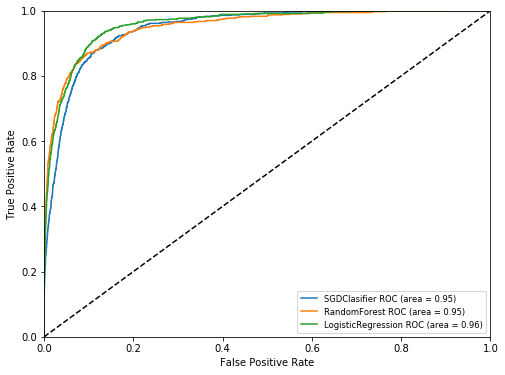

In [ ]:
pl.clf()
plt.figure(figsize=(8,6))

proba = sgd_clf.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
roc_auc = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('SGDClasifier', roc_auc))
proba = rf_clf.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
roc_auc = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandomForest', roc_auc))
proba = lr_clf.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
roc_auc = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LogisticRegression', roc_auc))

pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

## Part 2. Sites + new features

In [ ]:
sites = ['site%d' % i for i in range(1, 11)]
times = ['time%d' % i for i in range(1, 11)]
train_test_df_time = train_test_df[times].fillna(0)
new_feat = pd.DataFrame(index=train_test_df_time.index)
new_feat['start_hour'] = pd.DatetimeIndex(train_test_df_time['time1']).hour
new_feat['start_month'] = pd.DatetimeIndex(train_test_df_time['time1']).month
new_feat['day_of_week'] = pd.DatetimeIndex(train_test_df_time['time1']).dayofweek
new_feat['unique_sites'] = train_test_df[sites].nunique(axis=1,  dropna=True)
new_feat.head()

start_hour  start_month  day_of_week  unique_sites
session_id                                                    
1                   10            2            3             1
2                   11            2            5             7
3                   16           12            0             4
4                   10            3            4             1
5                   10            2            4             4

In [ ]:
new_feat_dum = pd.get_dummies(new_feat.loc[:, ['start_hour', 'start_month', 'day_of_week', 'unique_sites']],
                                  columns=new_feat.loc[:, ['start_hour', 'start_month', 'day_of_week', 'unique_sites']].columns,
                                  drop_first=False)

In [ ]:
new_feat_sparse = csr_matrix(new_feat_dum)

In [ ]:
all_sparse = csr_matrix(hstack([train_test_sparse, new_feat_sparse]))
X_train_sparse = all_sparse[:train_df.shape[0]]
X_test_sparse = all_sparse[train_df.shape[0]:]
y = train_df.iloc[:, -1].values

In [ ]:
divider = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:divider, :], y[:divider]
X_test, y_test  = X_train_sparse[divider:, :], y[divider:]

Stochastic Gradient Descent Classifier

In [ ]:
parameter_grid = {
            'loss': ['log', 'perceptron'],
            'penalty': ['l1', 'l2'],
            'alpha': [1e-04, 1e-05, 1e-06, 1e-07]
          }
clf = SGDClassifier()
rand_searcher = RandomizedSearchCV(clf, parameter_grid, scoring='roc_auc', n_iter=3, random_state=0)
rand_searcher.fit(X_train, y_train)
print(rand_searcher.best_score_)
print(rand_searcher.best_params_)

0.9856026226047392
{'penalty': 'l2', 'loss': 'log', 'alpha': 1e-05}


In [ ]:
sgd_clf = SGDClassifier(loss='log', alpha=1e-05, random_state=17, n_jobs=-1)
sgd_clf.fit(X_train, y_train)
sgd_test_pred_proba = sgd_clf.predict_proba(X_test)
roc_auc_score(y_test, sgd_test_pred_proba[:, 1])

0.9844585264314156

Random Forest Classifier

In [ ]:
parameter_grid = {
            'criterion': ['entropy', 'gini'],
            'max_depth': [10, 30, 100],
            'n_estimators': [10, 30, 100]
          }  
clf = RandomForestClassifier()
rand_searcher = RandomizedSearchCV(clf, parameter_grid, scoring='roc_auc', n_iter=3, random_state=0)
rand_searcher.fit(X_train, y_train)
print(rand_searcher.best_score_)
print(rand_searcher.best_params_)

0.9905634273256988
{'n_estimators': 100, 'max_depth': 100, 'criterion': 'entropy'}


In [ ]:
rf_clf = RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=100)
rf_clf.fit(X_train, y_train)
rf_test_pred_proba = rf_clf.predict_proba(X_test)
roc_auc_score(y_test, rf_test_pred_proba[:, 1])

0.9908864082901663

Logistic Regression

In [ ]:
lr_clf = LogisticRegression(random_state=1, max_iter = 300)
lr_clf.fit(X_train, y_train)
lr_test_pred_proba = lr_clf.predict_proba(X_test)
roc_auc_score(y_test, lr_test_pred_proba[:, 1])

0.987577261919104

Graph ROC AUC

<Figure size 432x288 with 0 Axes>

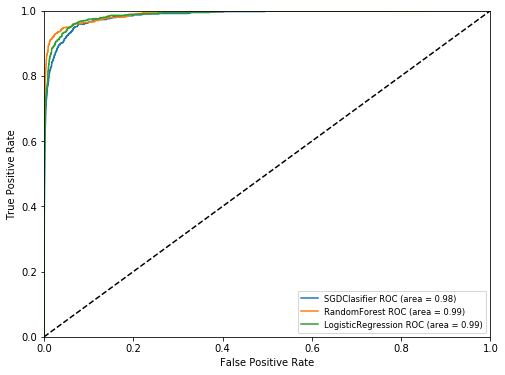

In [ ]:
pl.clf()
plt.figure(figsize=(8,6))

proba = sgd_clf.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
roc_auc = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('SGDClasifier', roc_auc))
proba = rf_clf.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
roc_auc = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('RandomForest', roc_auc))
proba = lr_clf.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
roc_auc = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LogisticRegression', roc_auc))

pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

In [ ]:
lr_clf.fit(X_train_sparse, y)
sgd_test_pred_proba = lr_clf.predict_proba(X_test_sparse)
result = sgd_test_pred_proba[:,1]

In [ ]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
write_to_submission_file(result, 'result.csv')

In [ ]:
files.download('result.csv')